In [259]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"


import celerite
from celerite import terms
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [260]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

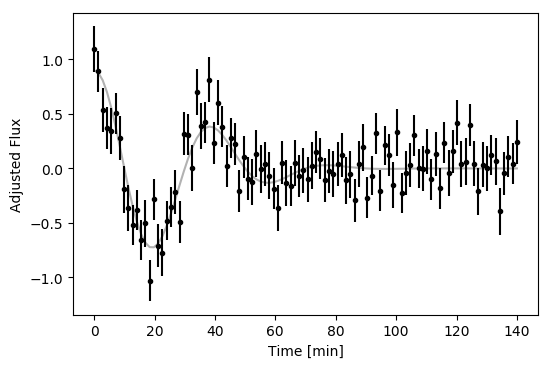

In [261]:
t = np.linspace(0, 140, 100)
QPP = qpp_model(t,0.9,0,30,40,0)
yerr = np.random.uniform(0.18, 0.22, len(t))

y = QPP + yerr * np.random.randn(len(t))
true_y = QPP

plt.plot(t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")



In [262]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [263]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -48.57054714716105


In [264]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -1.9475629062831388
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.73443548e-04,  -1.86872740e-03,  -1.42108547e-06,
        -1.42108547e-06,  -1.42108547e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 246
      nit: 32
   status: 0
  success: True
        x: array([ 0.0524706 , -1.96409147, -5.11230154, -6.31084329, -4.68254019])


In [265]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 0.052470602591222278),
             ('kernel:terms[0]:log_omega0', -1.9640914669171605),
             ('kernel:terms[1]:log_S0', -5.1123015371911871),
             ('kernel:terms[1]:log_Q', -6.3108432877427516),
             ('kernel:terms[1]:log_omega0', -4.6825401901436017)])

In [266]:
x = np.linspace(0, 140, 100)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

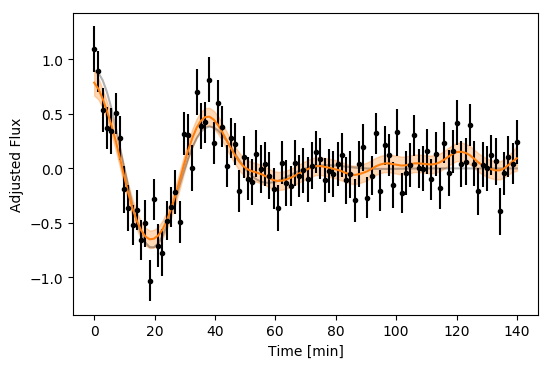

In [269]:
color = "#ff7f0e"
plt.plot(t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")